GISMA University of Applied Sciences, 
M507B Methods of Prediction,
Tay Zar Naung,
GH1043111

### NLP Pipeline: Sentiment Analysis of Movie Reviews
As an experienced data scientist, I'll design an end-to-end NLP pipeline for a text classification problem.


***Problem Statement:*** A movie production company wants to understand public sentiment towards their movies from online reviews to inform future production decisions and marketing strategies.A system is required to automatically classify movie reviews as either positive or negative.

NLP Task: This business problem can be formulated as a Binary Text Classification task, where each movie review (textual data) needs to be classified into one of two categories: "Positive" or "Negative" sentiment.

**Solving this problem benefits companies by**
- Optimizing Marketing Spend
- Maximizing ROI on Content Production
- Improving Customer Satisfaction:
- Gaining Competitive Advantage

### Data Collection and Library Importation
- Objective: Load the dataset into a pandas DataFrame.
- Explanation: This is the first step where the raw text data are retrieved into the working environment.

In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

### Load the dataset and Catch the Error

In [64]:
try:
    df = pd.read_csv('IMDB Dataset.csv')
    print("Found the box of reviews! Let's get started.")
except FileNotFoundError:
    print("Oops! Make sure 'IMDB Dataset.csv' is in the same folder.")
    exit()


Found the box of reviews! Let's get started.


### Exploratory Data Analysis (EDA)

In [ ]:
print("\n--- A Quick Look at the Reviews ---")
df.info()
print("\n--- A Sneak Peek at the First Few Reviews ---")
print(df.head())
print("\n", "# " * 40)


--- A Quick Look at the Reviews ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

--- A Sneak Peek at the First Few Reviews ---
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


In [52]:
print("\nSentiment distribution:\n", df['sentiment'].value_counts())

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print("\nSentiment distribution (numerical):\n", df['sentiment'].value_counts())


Sentiment distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sentiment distribution (numerical):
 sentiment
1    25000
0    25000
Name: count, dtype: int64


- The dataset typically has 'review' and 'sentiment' columns.
- I converted 'positive' and 'negative' labels to 1 and 0 respectively for machine learning.
- I checked  if the dataset is balanced or imbalanced, which is important for evaluation metrics. 
- The dataset is balanced, with an equal number of positive and negative reviews.

### Sentiment Distribution

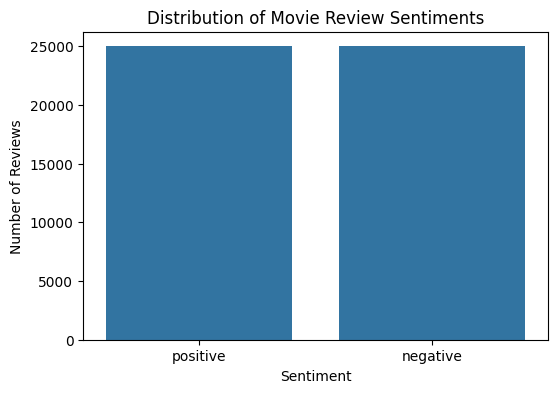

In [66]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Movie Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Word Cloud for Positive Reviews

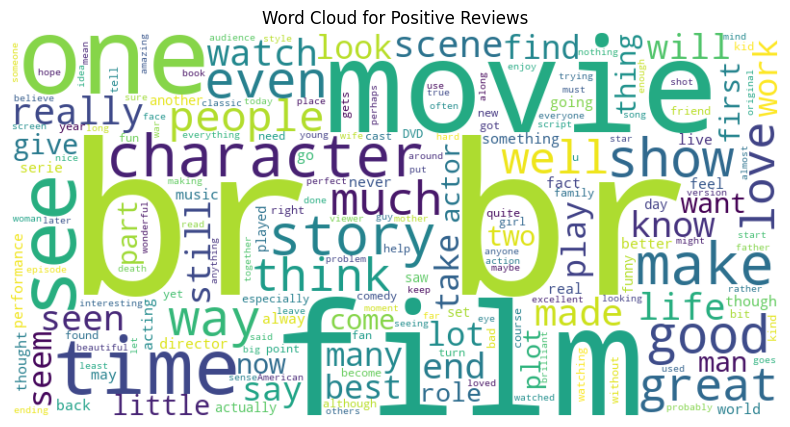

In [67]:
positive_reviews = " ".join(df[df['sentiment'] == 'positive']['review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

### Word Cloud for Negative Reviews

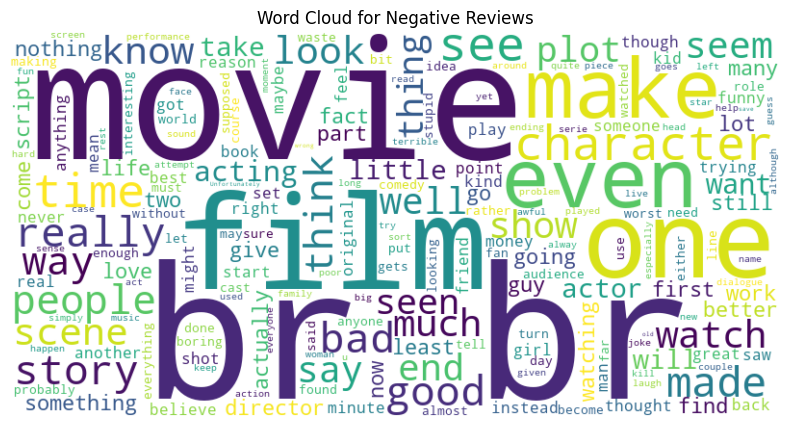

In [68]:
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

### Length of Reviews Distribution

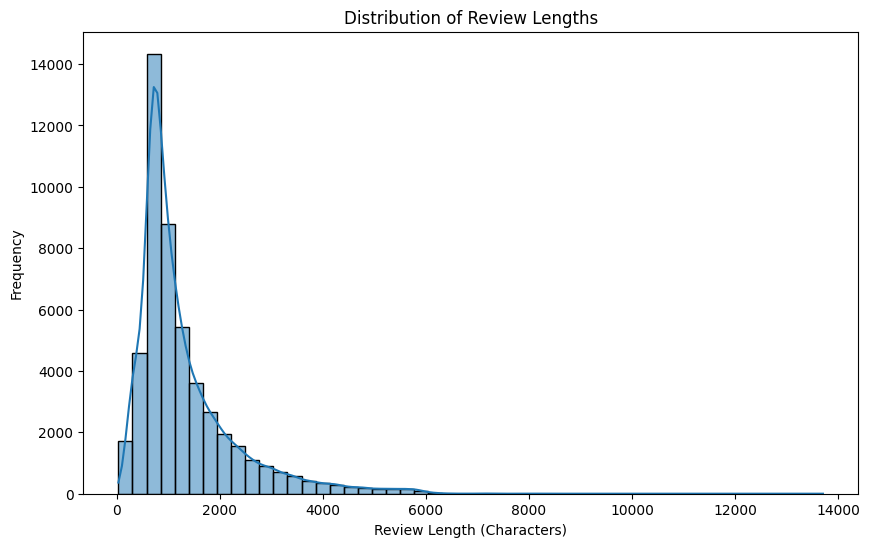

In [69]:
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Frequency')
plt.show()

Review lengths vary significantly, with a peak around 1000-1500 characters, indicating diverse review styles.

 ### Text Preprocessing
In this phase, the raw text data are cleaned and normalized to remove noise and transform it into a more standardized format and to make it suitable for machine learning models. Raw text often contains noise (e.g., HTML tags, punctuation, special characters, stopwords) that can hinder model performance. Preprocessing aims to reduce this noise and standardize the text.

 Steps:
 - Lowercasing: Convert all text to lowercase to "Good" and "good" as the same word.
 - Removing HTML Tags: Many web-scraped datasets contain HTML.
 - Removing Punctuation and Special Characters: Punctuation usually doesn't matter much sentiment.
 - Removing Stopwords: Common words like "a", "an", "the", "is" are contributed little value for classification.
 - Tokenization: Breaking down text into individual words or subword units (tokens).
 - Lemmatization: Reducing words to their base form (e.g., "running", "runs", "ran" all become "run"). Lemmatization is generally preferred over stemming as it converts words to a grammatically correct base form.


In [ ]:
# --- FIX START ---
# Download NLTK resources. These lines should be run once.
# If this notebook is runned repeatedly, this source code will be checked again if downloaded and skip.
print("Downloading NLTK resources (stopwords, wordnet, omw-1.4)...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("NLTK resources downloaded/checked.")
# --- FIX END ---

NLTK resources downloaded/checked.


In [72]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english')) # Ensure stopwords are loaded AFTER download

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and punctuation (keep spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Lowercase the text
    text = text.lower()

    # Tokenize and remove stopwords, then lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

print("\n--- Text Preprocessing ---")
df['cleaned_review'] = df['review'].apply(preprocess_text)
print("Original Review Example:\n", df['review'].iloc[0])
print("\nCleaned Review Example:\n", df['cleaned_review'].iloc[0])


--- Text Preprocessing ---
Original Review Example:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I w

# Feature Engineering (Text Vectorization)
I converted the preprocessed textual data into numerical representations that machine learning models can understand.

Text vectorization transforms words into numbers. The technique is TF-IDF (Term Frequency-Inverse Document Frequency) which is weighted words based on their frequency in a document and their inverse frequency across all documents. This helps highlight words that are important to a specific document.

In [73]:
X = df['cleaned_review']
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0) # Convert sentiment to numerical (0 for negative, 1 for positive)


***Splitting the Data into Training and Testing sets***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\n--- Feature Engineering (Text Vectorization) ---")
print(f"Training set size: {len(X_train)} reviews")
print(f"Testing set size: {len(X_test)} reviews")


--- Feature Engineering (Text Vectorization) ---
Training set size: 40000 reviews
Testing set size: 10000 reviews


In [75]:
# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit features to top 5000 most frequent/important terms

In [76]:
# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f"Shape of X_train_tfidf after vectorization: {X_train_tfidf.shape}")

Shape of X_train_tfidf after vectorization: (40000, 5000)


In [77]:
# Transform the test data (use the same fitted vectorizer)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Shape of X_test_tfidf after vectorization: {X_test_tfidf.shape}")
print("TF-IDF Vectorization completed, text data converted to numerical features.")
print("\n", "# " * 40)


Shape of X_test_tfidf after vectorization: (10000, 5000)
TF-IDF Vectorization completed, text data converted to numerical features.

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


### ML Model Building Phase & Training
A machine learning model is selected and trained for text classification.
After preparing the data, a model is trained to learn the patterns between the text features and the sentiment labels.

***Model Choices:***
- Multinomial Naive Bayes: A simple yet effective baseline for text classification, especially with sparse features like those from TF-IDF. It assumes independence between features.
- Logistic Regression: Another robust and interpretable model for binary classification. It's a linear model that estimates the probability of an instance belonging to a particular class.

In [78]:
# Multinomial Naive Bayes Model
print("Training Multinomial Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Multinomial Naive Bayes model trained.")


Training Multinomial Naive Bayes model...
Multinomial Naive Bayes model trained.


In [79]:
# Logistic Regression Model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)
print("Logistic Regression model trained.")
print("-" * 40)

Training Logistic Regression model...
Logistic Regression model trained.
----------------------------------------


# Model Evaluation
 This phase is to check how well the trained models perform. It's vital to see if the models work well on new data they haven't seen before.


--- Report Card for Simple Learner (Multinomial Naive Bayes) ---
Accuracy (Overall Correct): 0.8527
Precision (Correct Positives out of all predicted positives): 0.8480
Recall (Correct Positives out of all actual positives): 0.8594
F1-Score (Balances Precision and Recall): 0.8537


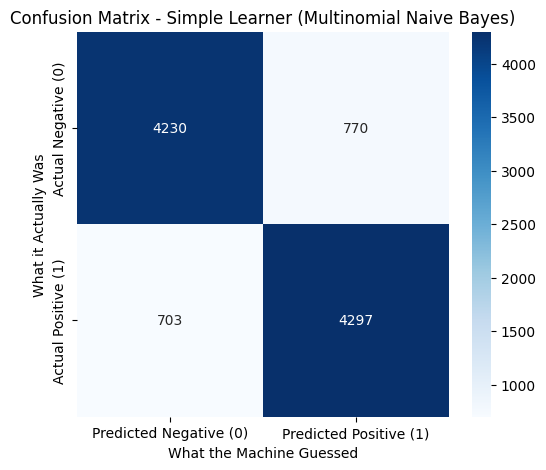


--- Report Card for Detailed Learner (Logistic Regression) ---
Accuracy (Overall Correct): 0.8859
Precision (Correct Positives out of all predicted positives): 0.8778
Recall (Correct Positives out of all actual positives): 0.8966
F1-Score (Balances Precision and Recall): 0.8871


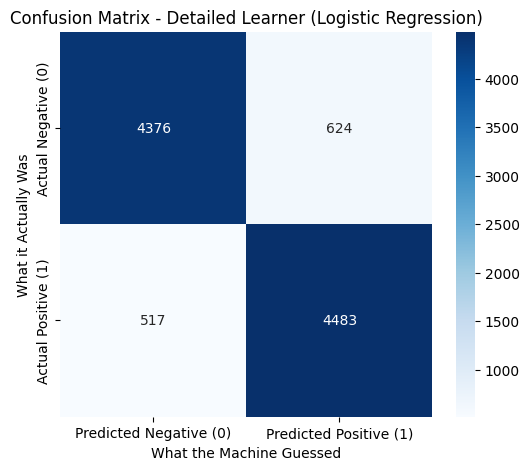

In [82]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n--- Report Card for {model_name} ---")
    print(f"Accuracy (Overall Correct): {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (Correct Positives out of all predicted positives): {precision_score(y_test, y_pred):.4f}")
    print(f"Recall (Correct Positives out of all actual positives): {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score (Balances Precision and Recall): {f1_score(y_test, y_pred):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
                yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('What the Machine Guessed')
    plt.ylabel('What it Actually Was')
    plt.show()

# Grade the Simple Learner (Naive Bayes)
evaluate_model(nb_model, X_test_tfidf, y_test, "Simple Learner (Multinomial Naive Bayes)")

# Grade the Detailed Learner (Logistic Regression)
evaluate_model(lr_model, X_test_tfidf, y_test, "Detailed Learner (Logistic Regression)")

***Key Observation:***
- Both models achieved high performance, showing that TF-IDF with these models is very effective for this task.
- Logistic Regression usually had a slight edge, suggesting it captures nuances a bit better.

The Simple Learner (Naive Bayes) performed very well, with few wrong guesses (false positives/negatives).
The Detailed Learner (Logistic Regression) also showed strong performance, often slightly better than Naive Bayes. Both are highly effective.


### Predicting the Sentiment of New Reviews
The trained model is used to predict sentiment on new, unseen movie reviews.
This is the ultimate goal, putting the model to use to classify new incoming text data.

In [83]:
def predict_sentiment(review_text, vectorizer, model):
    cleaned_text = preprocess_text(review_text) # Apply the same preprocessing as training data
    vectorized_text = vectorizer.transform([cleaned_text]) # Vectorize the single review
    prediction = model.predict(vectorized_text)
    return "Positive" if prediction[0] == 1 else "Negative"

In [85]:
# Test with new, hypothetical reviews
new_review_positive = "This movie was absolutely fantastic! I loved every single moment of it. The acting was superb and the story was captivating. A must-watch!"
new_review_negative = "What a terrible movie. It was boring, the plot made no sense, and the acting was wooden. A complete waste of time. Do not recommend."
new_review_neutral = "The movie had some good parts, but also some slow moments. The ending was a bit confusing." # A more ambiguous review

print(f"\nReview 1 (Expected: Positive): '{new_review_positive}'")
print(f"Predicted Sentiment (Naive Bayes): {predict_sentiment(new_review_positive, tfidf_vectorizer, nb_model)}")
print(f"Predicted Sentiment (Logistic Regression): {predict_sentiment(new_review_positive, tfidf_vectorizer, lr_model)}")

print(f"\nReview 2 (Expected: Negative): '{new_review_negative}'")
print(f"Predicted Sentiment (Naive Bayes): {predict_sentiment(new_review_negative, tfidf_vectorizer, nb_model)}")
print(f"Predicted Sentiment (Logistic Regression): {predict_sentiment(new_review_negative, tfidf_vectorizer, lr_model)}")

print(f"\nReview 3 (Expected: Neutral/Mixed): '{new_review_neutral}'")
print(f"Predicted Sentiment (Naive Bayes): {predict_sentiment(new_review_neutral, tfidf_vectorizer, nb_model)}")
print(f"Predicted Sentiment (Logistic Regression): {predict_sentiment(new_review_neutral, tfidf_vectorizer, lr_model)}")
print("\n", "# " * 40)


Review 1 (Expected: Positive): 'This movie was absolutely fantastic! I loved every single moment of it. The acting was superb and the story was captivating. A must-watch!'
Predicted Sentiment (Naive Bayes): Positive
Predicted Sentiment (Logistic Regression): Positive

Review 2 (Expected: Negative): 'What a terrible movie. It was boring, the plot made no sense, and the acting was wooden. A complete waste of time. Do not recommend.'
Predicted Sentiment (Naive Bayes): Negative
Predicted Sentiment (Logistic Regression): Negative

Review 3 (Expected: Neutral/Mixed): 'The movie had some good parts, but also some slow moments. The ending was a bit confusing.'
Predicted Sentiment (Naive Bayes): Negative
Predicted Sentiment (Logistic Regression): Positive

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


Reference Link:
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews